In [1]:
from cliff_game import CliffGame, Action
from algorithms import Sarsa
from plotting import plot_rewards

In [2]:
cg = CliffGame()
print(cg)

reward = 0



|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [3]:
r, game_over = cg.move(Action.UP)
reward += r
print(reward, game_over)
print(cg)

-1 False

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|   * |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [4]:
seq = [Action.RIGHT, Action.RIGHT, Action.DOWN, Action.RIGHT]

for i, action in enumerate(seq):
    print(f"{i+1}/{len(seq)} Moving {action.name}")
    r, game_over = cg.move(action)
    reward += r
    if game_over:
        print("Game Over")
        break

print("\nTotal reward:", reward)
print(cg)

1/4 Moving RIGHT
2/4 Moving RIGHT
3/4 Moving DOWN
Game Over

Total reward: -103

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [5]:
N_EPISODES = 100
sarsa = Sarsa(cg)
rewards = []
for i in range(N_EPISODES):
    cg.reset()
    _, _, r = sarsa.run()
    rewards.append(r)
    # print(" ", r)

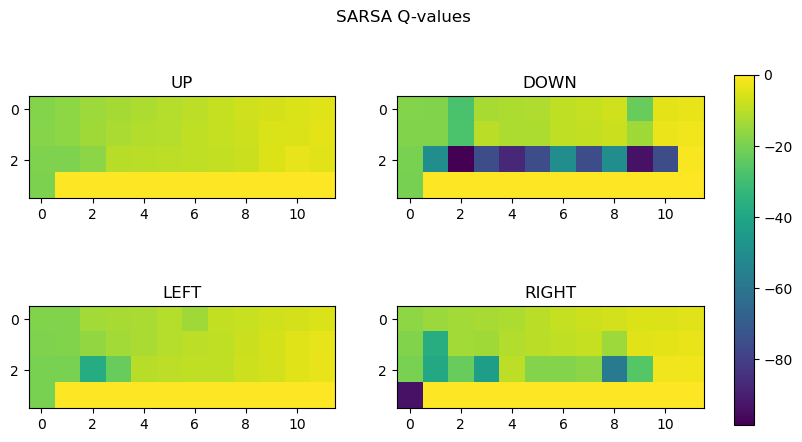

In [6]:
sarsa.plot_q_values()


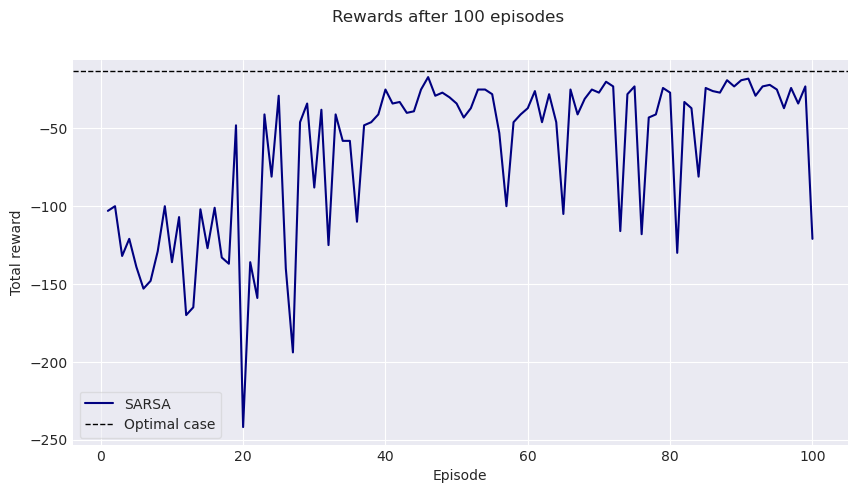

In [7]:
plot_rewards(dict(SARSA=rewards), colors=dict(SARSA='navy'), title=f"Rewards after {N_EPISODES} episodes", optimal=-13)

In [8]:
_, policy_actions, _ = sarsa.get_current_policy()
policy_actions

array([[<Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>, <Action.DOWN: 2>],
       [<Action.UP: 1>, <Action.UP: 1>, <Action.RIGHT: 4>,
        <Action.DOWN: 2>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.UP: 1>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>, <Action.DOWN: 2>],
       [<Action.UP: 1>, <Action.UP: 1>, <Action.UP: 1>, <Action.UP: 1>,
        <Action.RIGHT: 4>, <Action.LEFT: 3>, <Action.LEFT: 3>,
        <Action.UP: 1>, <Action.LEFT: 3>, <Action.UP: 1>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>],
       [<Action.UP: 1>, '', '', '', '', '', '', '', '', '', '', '']],
      dtype=object)

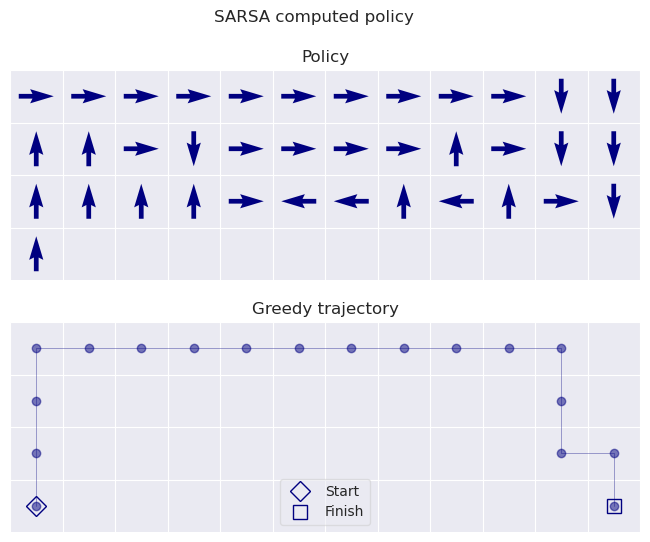

In [9]:
sarsa.plot_current_policy(color='navy')